## Aggregate the network with an optimization method

In [33]:
import sys
sys.path.append('../src')
import utils_mistral as utils
import test_mistral_copy as models
import visuals as v
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product
import xarray as xr
import importlib

importlib.reload(models)
importlib.reload(utils)
importlib.reload(v)

<module 'visuals' from 'c:\\Users\\g630d\\Documents\\00_Cours\\2024-2025_MIT\\00 Thesis\\Dev\\notebooks\\../src\\visuals.py'>

In [34]:
config = utils.Config(demand = "k-interpolation", k_weight_demand= 1)

In [35]:
nodes_df, demand_df, wind_df, solar_df = utils.DataProcessor.import_and_interpolate_data(config)

Number of duplicates deleted in nodes_df: 2238


In [36]:
# Load CSV data
TimeSeries = {'wind': wind_df, 'solar': solar_df};

In [37]:
network = utils.Network(nodes_df, demand_df, TimeSeries, config)

The 'features' dictionary has been created and can be accessed as '.features'
It is a dictionary with keys for each node in range(0, 2605).
Each value is a dictionary with the features of that node.

Example structure:
network.features[0].keys() = dict_keys(['position', 'time_series', 'duration_curves', 'ramp_duration_curves', 'correlation', 'supply_demand_mismatch'])

Details:
  - Position: A tuple (latitude, longitude) of that node.
  - Time series: A dictionary with keys for each time series type in dict_keys(['wind', 'solar'])
    and values as the time series itself.
  - Duration Curves: A dictionary with keys for each time series type in dict_keys(['wind', 'solar'])
    and values as the duration curve of the time series.
  - Ramp Duration Curves (RDCs): A dictionary with keys for each time series type dict_keys(['wind', 'solar'])
    and values as the RDC (found by differentiating and subsequently sorting) of the time series.
  - Correlation: A dictionary with keys as tuples of 

In [25]:
config.time_scale = 'yearly'

In [27]:
supply_demand_mismatch = []
for i in network.features.keys():
    supply_demand_mismatch.append(network.features[i]["supply_demand_mismatch"]["solar"])

supply_demand_mismatch = np.array(supply_demand_mismatch)

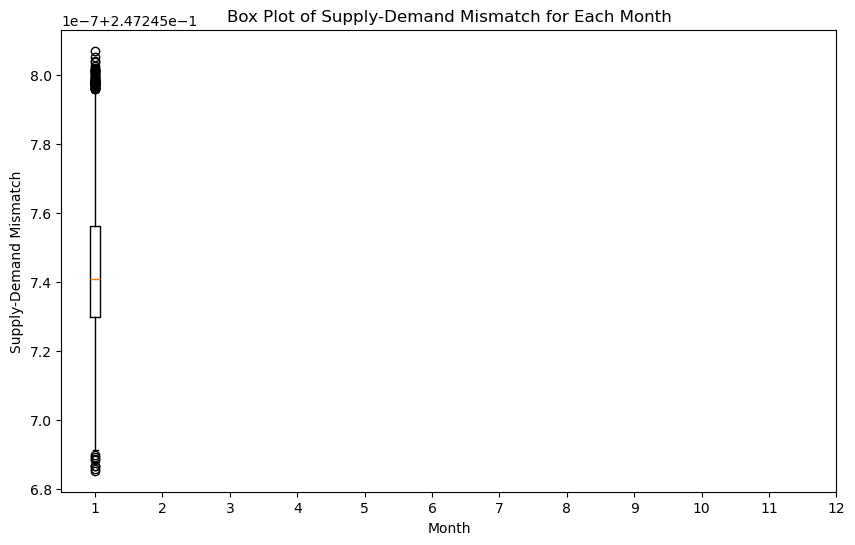

In [28]:
# Create the box plot
plt.figure(figsize=(10, 6))
plt.boxplot(supply_demand_mismatch)

# Customize the plot
plt.xlabel('Month')
plt.ylabel('Supply-Demand Mismatch')
plt.title('Box Plot of Supply-Demand Mismatch for Each Month')
plt.xticks(ticks=np.arange(1, 13), labels=[i for i in range(1, 13)])

# Show the plot
plt.show()

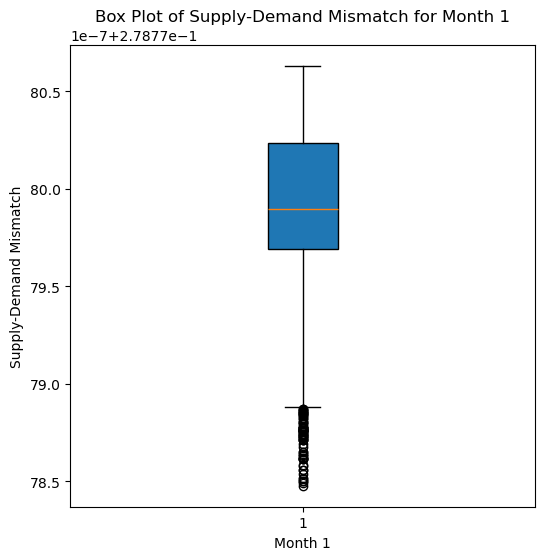

In [144]:
first_month_data = supply_demand_mismatch[:, 0]

# Create the box plot for the first month
plt.figure(figsize=(6, 6))
plt.boxplot(first_month_data, patch_artist=True)

# Customize the plot
plt.xlabel('Month 1')
plt.ylabel('Supply-Demand Mismatch')
plt.title('Box Plot of Supply-Demand Mismatch for Month 1')

# Show the plot
plt.show()

In [38]:
aggregator = models.SpatialAggregation(network.features, config)

In [30]:
aggregator.distance_metrics

NameError: name 'aggregator' is not defined

In [43]:
optimized_assignment_dict = aggregator.optimize()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 6788631 rows, 6788630 columns and 20360680 nonzeros
Model fingerprint: 0x4427af3e
Variable types: 0 continuous, 6788630 integer (6788630 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-07, 7e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 0 rows and 0 columns (presolve time = 5s) ...
Presolve removed 0 rows and 0 columns (presolve time = 10s) ...
Presolve removed 0 rows and 0 columns (presolve time = 15s) ...
Presolve removed 0 rows and 0 columns (presolve time = 20s) ...
Presolve removed 0 rows and 0 columns (presolve time = 25s) ...
Presolve removed 0 rows and 0 columns (presolve time = 30s) ...
Presolve removed 0 rows and 0 columns (pres

GurobiError: Out of memory

In [39]:
cluster_assignment_dict = aggregator.cluster_KMedoids()

KeyError: 'ramp_duration_curves_distance'

In [45]:
eval_KMedoids = aggregator.compute_metrics(aggregation_method = 'kmedoids', type="custom")

In [19]:
eval_opti = aggregator.compute_metrics(aggregation_method = 'optimization', type="custom")

In [79]:
importlib.reload(v)
visualizer = v.Visualization(aggregator)

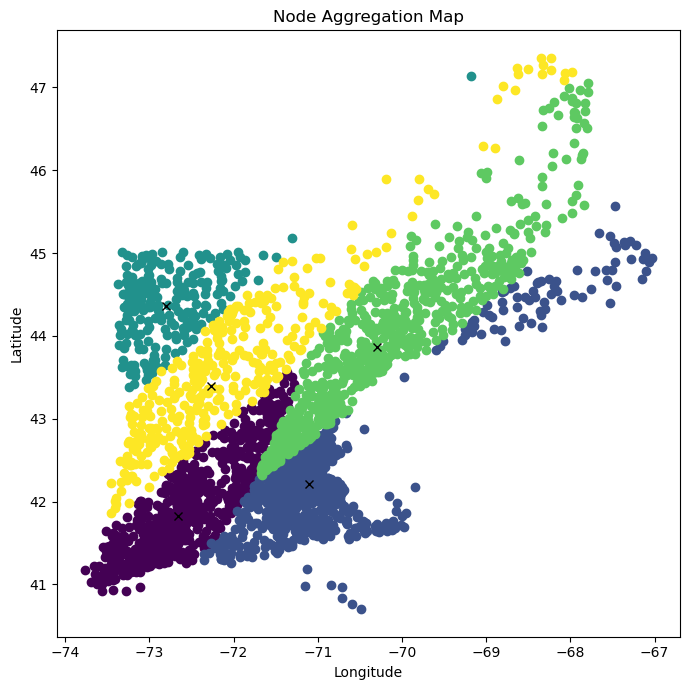

In [80]:
visualizer.plot_map(aggregation_method='kmedoids')

In [ ]:
visualizer.plot_map(aggregation_method='optimization')

In [66]:
print('kmedoids')
print('- Number of clusters: ', len(cluster_centers))
print('- Representatives: ', cluster_centers)
print('- Number of nodes in each cluster:')
for i in range(len(cluster_centers)):
    print(f'  Cluster {i}: {len(cluster_assignment_dict[i])} nodes')

print("optimization")
print('- Number of clusters: ', len(opti_rep))
print('- Representatives: ', opti_rep)
print('- Number of nodes in each cluster:')
for i in range(len(opti_rep)):
    print(f'  Cluster {i}: {int(assignment_matrix_result[:, opti_rep[i]].sum())} nodes')

kmedoids
- Number of clusters:  5
- Representatives:  [113, 1015, 2578, 674, 1825]
- Number of nodes in each cluster:
  Cluster 0: 639 nodes
  Cluster 1: 227 nodes
  Cluster 2: 647 nodes
  Cluster 3: 327 nodes
  Cluster 4: 765 nodes
optimization
- Number of clusters:  5
- Representatives:  [113, 672, 1015, 1825, 2578]
- Number of nodes in each cluster:
  Cluster 0: 639 nodes
  Cluster 1: 325 nodes
  Cluster 2: 229 nodes
  Cluster 3: 765 nodes
  Cluster 4: 647 nodes


In [91]:
for i in range(5):
    cluster_assignment_dict.pop(i)

In [96]:
importlib.reload(models)
temp = models.TemporalAggregation(aggregator,cluster_assignment_dict)

In [98]:
a = temp.aggregate()